# Set up 


In [30]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import sys
import scipy.optimize as optimize
import threading
from scipy.optimize import LinearConstraint
from datetime import datetime

In [31]:
path="./" + "sidedata/"
filename = path + "Alldata2.csv"

df=pd.read_csv(filename, index_col=None)

df = df[df["FileCondi"]!="CMat"]
df['Probtype'] = np.where(df['Stimkind']==1, "CM",
                   np.where(df['Stimkind']==0, "AN",
                   np.where(df['Stimkind']==3, 'VM',"wrong")))

df['Oldnew'] = np.where(df['Old']==1, "old",
                   np.where(df['Old']==2, "new","wrong"))
df['Error'] = 1-df['Correctness']
df0=df.copy()# = df.copy()
# df_giver.columns=df_giver.columns.droplevel(1)
df_org = df[df['RT']<2000]
df = df_org.groupby(["Oldnew","Setsize","Probtype","Lag","Error","FileCondi"])[["RT"]].agg(["mean"])
# df[["Correctness","Error"]]
# df.groupby("Error")
df.index.name = 'Setsize'
df.reset_index(inplace=True)
# df["Error"]


df_err = df_org.groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["Error"]].agg(["mean"]).reset_index()
df_crt = df_org[df_org["Error"]==0].\
groupby(["Oldnew","Setsize","Probtype","Lag","FileCondi"])[["RT"]].agg(["mean"]).reset_index()

df_err.columns = df_err.columns.droplevel(1)
df_crt.columns = df_crt.columns.droplevel(1)

df_err = df_err.reset_index()
df_crt = df_crt.reset_index()
# df_err.reindex(np.arange(1,df_err.shape[0]))
# df_crt.reindex(np.arange(1,df_crt.shape[0]))

# R funcitons

In [32]:
%get df_giver --from Python3
# library(plyr)
library(dplyr)
library(ggplot2)
library(lattice)
library(Rmisc)
library(stringr)
library(tidyr)
library(cowplot)
library(plotly)
source("functions_fromr.r")

Variable df_giver does not exist


In [33]:
# levels(as.factor(df_giver$FileCondi))
files = c('ANpure' ,'CMpure', 'MIX', 'MIX2', 'VMpure')
c("alpha","beta","s",paste("c",files,sep="_"),paste(rep(c("BDDo","BDDn"),5),rep(files,each=2),sep="_"),
 "t0","t0an","kappa",
 'F_ANpure_AN_oldiold_oldinew',
 'F_CMpure_CM_oldiold_oldinew',
 'L_CMpure_CM_oldiold_newinew',
 'L_CMpure_CM_oldinew_newiold',
 'F_VMpure_VM_oldiold_oldinew',
 'L_VMpure',
 'F_MIX_CM_oldiold_oldinew',
 'L_MIX_CM_oldiold_newinew',
 'L_MIX_CM_oldinew_newiold',
 'F_MIX_AN_oldiold_oldinew',
 'F_MIX2_CM_oldiold_oldinew',
 'L_MIX2_CM_oldiold_newinew',
 'L_MIX2_CM_oldinew_newiold',
 'F_MIX2_AN_oldiold_oldinew')


[1] "alpha"                       "beta"                       
 [3] "s"                           "c_ANpure"                   
 [5] "c_CMpure"                    "c_MIX"                      
 [7] "c_MIX2"                      "c_VMpure"                   
 [9] "BDDo_ANpure"                 "BDDn_ANpure"                
[11] "BDDo_CMpure"                 "BDDn_CMpure"                
[13] "BDDo_MIX"                    "BDDn_MIX"                   
[15] "BDDo_MIX2"                   "BDDn_MIX2"                  
[17] "BDDo_VMpure"                 "BDDn_VMpure"                
[19] "t0"                          "t0an"                       
[21] "kappa"                       "F_ANpure_AN_oldiold_oldinew"
[23] "F_CMpure_CM_oldiold_oldinew" "L_CMpure_CM_oldiold_newinew"
[25] "L_CMpure_CM_oldinew_newiold" "F_VMpure_VM_oldiold_oldinew"
[27] "L_VMpure"                    "F_MIX_CM_oldiold_oldinew"   
[29] "L_MIX_CM_oldiold_newinew"    "L_MIX_CM_oldinew_newiold"   
[31] "F_MIX_AN_oldiold_oldinew"    "F_MIX2_CM_oldiold_oldinew"  
[33] "L_MIX2_CM_oldiold_newinew"   "L_MIX2_CM_oldinew_newiold"  
[35] "F_MIX2_AN_oldiold_oldinew"

    for icondi in filecondis:
        x=threading.Thread(target=work_thread_p,args=(icondi,))
        threads.append(x)
        x.start()
    for icondi, thread in enumerate(threads):
        thread.join()

## Some global setting

In [34]:
global vary_ss, give_c2
vary_ss=0
give_c2=0

global nameset

nameset = df_org["FileCondi"].astype("category").cat.categories.to_numpy()

# ALL Parameter

In [60]:
global alpha, beta, s, c ,Old_crit ,New_crit ,\
    t0 ,kao , F, L, c2
  
alpha={}; beta ={}; s = {}; F = {}; L = {}; c={}; t0={}; Old_crit={}; New_crit={}


# boost = 1.05
alpha["all"] = 0.19
# alpha['CM'] = 0.1969 
# alpha['VM'] = 0.1969 
# alpha["AN"]=0.84

beta["all"] =1.2
# beta['CM'] = 1.228
# beta['VM'] = 1.228
# beta["AN"]= 1.708

s["all"]=0.01
s["ss24"]=0.01
s["ss8"]=0.01
# s["AN"] = 0.01
# s["CM"] = 0.02
# s["VM"] = 0.02
c["ANpure"] = 0.3938
c["CMpure"] = 0.3938
c["VMpure"] = 0.3938
c["MIX"] = 0.3938
c["MIX2"] = 0.3938
# c["CMat"] = 0.3938
c2=0.3
Old_crit["ANpure"] = 1.9197
New_crit["ANpure"] = -2.33
Old_crit["CMpure"] = 1.9197
New_crit["CMpure"] = -2.33
Old_crit["VMpure"] = 1.9197
New_crit["VMpure"] = -2.33
Old_crit["MIX"] = 1.9197
New_crit["MIX"] = -2.33
Old_crit["MIX2"] = 1.9197
New_crit["MIX2"] = -2.33

t0["all"] = 699.98
t0["ann"] =  699.98
kao = 37

#---CM
F["ANpure_AN_oldiold_oldinew"] = 0.2

F["CMpure_CM_oldiold_oldinew"] = 0.2
L["CMpure_CM_oldiold_newinew"] = 0.2
L["CMpure_CM_oldinew_newiold"] = 0

F["VMpure_VM_oldiold_oldinew"] = 0.2
L["VMpure"] = 0.2 

F["MIX_CM_oldiold_oldinew"] = 0.2
L["MIX_CM_oldiold_newinew"] = 0.2
L["MIX_CM_oldinew_newiold"] = 0.2
F["MIX_AN_oldiold_oldinew"] = 0.2

F["MIX2_CM_oldiold_oldinew"] = 0.2
L["MIX2_CM_oldiold_newinew"] = 0.2
L["MIX2_CM_oldinew_newiold"] = 0.2
F["MIX2_AN_oldiold_oldinew"] = 0.2




# Assign LTM global

In [36]:
def assign_LTM_global(Filecondi,item_condi, walk, item):
    
    global F,L,Fnow,Lnow
    if Filecondi != "VMpure":
        if item_condi == "CM":

            if walk+"i"+item == "oldiold" or walk+"i"+item == "oldinew":

                Fnow = F[Filecondi+"_CM_oldiold_oldinew"]
            else: Fnow = 0

            if walk+"i"+item == "oldiold" or walk+"i"+item == "newinew":

                Lnow = L[Filecondi+"_CM_oldiold_newinew"]
            elif walk+"i"+item == "oldinew" or walk+"i"+item == "newiold":

                Lnow = L[Filecondi+"_CM_oldinew_newiold"]
            else: Lnow=0

        elif item_condi == "AN":

            if walk+"i"+item == "oldiold" or walk+"i"+item == "oldinew":

                Fnow = F[Filecondi+"_AN_oldiold_oldinew"]
            else: Fnow=0

            Lnow = 0
            
        else: print("wrong condi 1",Filecondi,item_condi, walk+"i"+item)
            
    elif Filecondi == "VMpure":
        
        if item_condi == "VM":
            if walk+"i"+item == "oldiold" or walk+"i"+item == "oldinew":
                Fnow = F["VMpure_VM_oldiold_oldinew"]
            else: Fnow = 0
        else: print("wrong condi 2")
            
        Lnow = L["VMpure"]
    else:
        print("wrong filecondi")
    
    return(Fnow + Lnow)

assign_LTM_global("MIX","AN","old","old")


0.2

# Calc A (activation)

In [37]:

def calcA(df):

    
    dnow = df
    a = np.zeros((dnow.shape[0], 8))  #activation
    

    betanow=beta["all"] 
    alphanow=alpha["all"]
    
    m = np.array([(j**(-betanow) + alphanow) for j in np.arange(1,9)])
    
    for j in range(1,9):

        indexj = j-1
        
        
        if vary_ss==0:
            
            a[dnow["Lag"]==j,indexj] = m[indexj]
            a[dnow["Lag"]!=j,indexj] = m[indexj] * s["all"]
        else:
            a[np.logical_and(dnow["Lag"]!=j,dnow["Setsize"]!=8),indexj] = m[indexj] * s["ss24"]
            a[np.logical_and(dnow["Lag"]!=j,dnow["Setsize"]==8),indexj] = m[indexj] * s["ss8"]
            a[dnow["Lag"]==j,indexj] = m[indexj]
        
        
#         print(m[indexj] * s["all"])
    for i in range(a.shape[0]): a[i,dnow['Setsize'].iloc[i]:] = 0 #a_ij suit for the correct amount of setsize
    debug = 0
    if debug==1:
        for i in range(a.shape[0]):
            print(i, "begin\n","a is",a[i].round(5),\
                  "\n m is", np.array(m).round(3),"\n Probtype is",\
                  "\n Lag is ",dnow['Lag'].iloc[i],\
                  "\n Setsize is", dnow["Setsize"].iloc[i],\
                  "\n Probtype:",\
                  dnow["Probtype"].iloc[i],\
                  "\n Oldnew: ",dnow["Oldnew"].iloc[i],\
                  "\n Ai is", a[i,:].sum().round(2),\
                  "\n snow", s["all"],\
                 "\n------------------------------------------------" )

    
    A = a.sum(axis = 1)
    
    return(A)

# print(calcA(df))

A0=calcA(df)
show =[df["FileCondi"].iloc[i]+\
        "-- "+A0[i].round(5).astype(str)+\
      "--"+ df["Setsize"].iloc[i].astype(str)+\
      "--"+df["Probtype"].iloc[i]+\
      "--"+df["Oldnew"].iloc[i] for i in range(A0.size)]
print(np.sort(show))

['ANpure-- 0.01815--2--AN--new' 'ANpure-- 0.01815--2--AN--new'
 'ANpure-- 0.02652--4--AN--new' 'ANpure-- 0.02652--4--AN--new'
 'ANpure-- 0.03853--8--AN--new' 'ANpure-- 0.03853--8--AN--new'
 'ANpure-- 0.30827--8--AN--old' 'ANpure-- 0.30827--8--AN--old'
 'ANpure-- 0.32246--8--AN--old' 'ANpure-- 0.32246--8--AN--old'
 'ANpure-- 0.34194--8--AN--old' 'ANpure-- 0.34194--8--AN--old'
 'ANpure-- 0.37014--8--AN--old' 'ANpure-- 0.37014--8--AN--old'
 'ANpure-- 0.40219--4--AN--old' 'ANpure-- 0.40219--4--AN--old'
 'ANpure-- 0.4142--8--AN--old' 'ANpure-- 0.4142--8--AN--old'
 'ANpure-- 0.47953--4--AN--old' 'ANpure-- 0.47953--4--AN--old'
 'ANpure-- 0.49153--8--AN--old' 'ANpure-- 0.49153--8--AN--old'
 'ANpure-- 0.63718--2--AN--old' 'ANpure-- 0.63718--2--AN--old'
 'ANpure-- 0.64555--4--AN--old' 'ANpure-- 0.64555--4--AN--old'
 'ANpure-- 0.65755--8--AN--old' 'ANpure-- 0.65755--8--AN--old'
 'ANpure-- 1.19625--2--AN--old' 'ANpure-- 1.19625--2--AN--old'
 'ANpure-- 1.20462--4--AN--old' 'ANpure-- 1.20462--4--AN-

# Calc p (drift rate)

In [38]:
df

,Oldnew,Setsize,Probtype,Lag,Error,FileCondi,RT
,,,,,,,mean
0,new,2,AN,0,0,ANpure,808.779720
1,new,2,AN,0,0,MIX,749.161058
2,new,2,AN,0,0,MIX2,903.858079
3,new,2,AN,0,1,ANpure,801.656250
4,new,2,AN,0,1,MIX,844.000000
...,...,...,...,...,...,...,...
230,old,8,VM,6,1,VMpure,972.575000
231,old,8,VM,7,0,VMpure,964.521739
232,old,8,VM,7,1,VMpure,868.483871


In [39]:
# F["AN_oldiold_oldinew"] = 0.099
def calcp(df):
    
    A = calcA(df)
    dnow = df
    p = np.repeat(3.0, A.shape[0])
#     print(p.size)
    filecondis = dnow["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name

    for icondi in filecondis:
        
        #only ieterate through probs in that condition
        probs = dnow[dnow["FileCondi"]==icondi]["Probtype"].astype("category").cat.categories.to_numpy()
        for iprob in probs:

            for ion in ["old","new"]:
                    
                tf_ion = (dnow['Oldnew'] == ion)
                tf_iprob = (dnow['Probtype'] == iprob)
                tf_icondi = (dnow["FileCondi"] == icondi)
                
                tf_combi1 = np.logical_and(tf_ion, tf_iprob)
                tf_all = np.logical_and(tf_combi1,tf_icondi)

                IR_old_current = assign_LTM_global(icondi,iprob,"old",ion)
                IR_new_current = assign_LTM_global(icondi, iprob,"new",ion)
#                 print("**",icondi,iprob,"oldi"+ion+"--",IR_old_current,
#                       "newi"+ion+"--",IR_new_current)

                p[tf_all] = (A[tf_all] + IR_old_current)/(A[tf_all] + IR_old_current + c[icondi] + IR_new_current)
#                 print(tf_all.sum(),"***")
#                 print("**",icondi,iprob,"oldi"+ion+"--",IR_old_current,
#                                       "newi"+ion+"--",IR_new_current, p[tf_all])

    return(np.array(p))


p0=calcp(df)
show =[df["FileCondi"].iloc[i]+\
       "--"+df["Probtype"].iloc[i]+\
       "--"+ df["Setsize"].iloc[i].astype(str)+\
       "--"+df["Oldnew"].iloc[i]+\
       "-- "+p0[i].round(5).astype(str) for i in range(A0.size)]
print(np.sort(show))


['ANpure--AN--2--new-- 0.35649' 'ANpure--AN--2--new-- 0.35649'
 'ANpure--AN--2--old-- 0.68009' 'ANpure--AN--2--old-- 0.68009'
 'ANpure--AN--2--old-- 0.78001' 'ANpure--AN--2--old-- 0.78001'
 'ANpure--AN--4--new-- 0.36517' 'ANpure--AN--4--new-- 0.36517'
 'ANpure--AN--4--old-- 0.60462' 'ANpure--AN--4--old-- 0.60462'
 'ANpure--AN--4--old-- 0.6331' 'ANpure--AN--4--old-- 0.6331'
 'ANpure--AN--4--old-- 0.68225' 'ANpure--AN--4--old-- 0.68225'
 'ANpure--AN--4--old-- 0.78103' 'ANpure--AN--4--old-- 0.78103'
 'ANpure--AN--8--new-- 0.37722' 'ANpure--AN--8--new-- 0.37722'
 'ANpure--AN--8--old-- 0.56345' 'ANpure--AN--8--old-- 0.56345'
 'ANpure--AN--8--old-- 0.57021' 'ANpure--AN--8--old-- 0.57021'
 'ANpure--AN--8--old-- 0.57916' 'ANpure--AN--8--old-- 0.57916'
 'ANpure--AN--8--old-- 0.59147' 'ANpure--AN--8--old-- 0.59147'
 'ANpure--AN--8--old-- 0.60933' 'ANpure--AN--8--old-- 0.60933'
 'ANpure--AN--8--old-- 0.63716' 'ANpure--AN--8--old-- 0.63716'
 'ANpure--AN--8--old-- 0.6853' 'ANpure--AN--8--old-- 0.68

In [40]:
# time1=time.time()

# print("time",time.time()-time1)
# p0=calcp(df)
# show =[df["FileCondi"].iloc[i]+\
#        "--"+df["Probtype"].iloc[i]+\
#        "--"+ df["Setsize"].iloc[i].astype(str)+\
#        "--"+df["Oldnew"].iloc[i]+\
#        "-- "+p0[i].round(5).astype(str) for i in range(A0.size)]
# print(np.sort(show))


dd = df[df['FileCondi']=="MIX"]
p0=calcA(dd)
show =[dd["FileCondi"].iloc[i]+\
       "--"+dd["Probtype"].iloc[i]+\
       "--"+ dd["Setsize"].iloc[i].astype(str)+\
       "--"+dd["Oldnew"].iloc[i]+\
       "-- "+p0[i].round(5).astype(str) for i in range(p0.size)]
print(np.sort(show))

['MIX--AN--2--new-- 0.01815' 'MIX--AN--2--new-- 0.01815'
 'MIX--AN--2--old-- 0.63718' 'MIX--AN--2--old-- 0.63718'
 'MIX--AN--2--old-- 1.19625' 'MIX--AN--2--old-- 1.19625'
 'MIX--AN--4--new-- 0.02652' 'MIX--AN--4--new-- 0.02652'
 'MIX--AN--4--old-- 0.40219' 'MIX--AN--4--old-- 0.40219'
 'MIX--AN--4--old-- 0.47953' 'MIX--AN--4--old-- 0.47953'
 'MIX--AN--4--old-- 0.64555' 'MIX--AN--4--old-- 0.64555'
 'MIX--AN--4--old-- 1.20462' 'MIX--AN--4--old-- 1.20462'
 'MIX--AN--8--new-- 0.03853' 'MIX--AN--8--new-- 0.03853'
 'MIX--AN--8--old-- 0.30827' 'MIX--AN--8--old-- 0.30827'
 'MIX--AN--8--old-- 0.32246' 'MIX--AN--8--old-- 0.32246'
 'MIX--AN--8--old-- 0.34194' 'MIX--AN--8--old-- 0.34194'
 'MIX--AN--8--old-- 0.37014' 'MIX--AN--8--old-- 0.37014'
 'MIX--AN--8--old-- 0.4142' 'MIX--AN--8--old-- 0.4142'
 'MIX--AN--8--old-- 0.49153' 'MIX--AN--8--old-- 0.49153'
 'MIX--AN--8--old-- 0.65755' 'MIX--AN--8--old-- 1.21663'
 'MIX--CM--2--new-- 0.01815' 'MIX--CM--2--new-- 0.01815'
 'MIX--CM--2--old-- 0.63718' 'MIX

# RW 

In [41]:

def calc_theoretical_RW(df, which):
    
    #which = "err" or 'crt'

    A = calcA(df)
    p = calcp(df)
    q = 1-p
    
    dnow = df
    filecondis = dnow["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name
    
    p_resp_old = np.zeros(p.size)
    pred_correct = np.zeros(p.size)
    pred_rt = np.zeros(p.size)

    theta1 = np.zeros(p.size)
    theta2 = np.zeros(q.size)
    theta11 = np.zeros(p.size)
    theta22 = np.zeros(q.size)
    exp_nstep = np.zeros(p.shape[0])
    
    for ifile in filecondis: 
        
        gen_tf = dnow["FileCondi"]==ifile
        AA = Old_crit[ifile]
        BB = -New_crit[ifile] # bb is a postive number
        
        if which=="crt":
            
            pq = (p[gen_tf]/q[gen_tf])
            theta1[gen_tf] = (pq**(AA+BB)+1)/(pq**(AA+BB)-1)
            theta2[gen_tf] = (pq**BB+1)/(pq**BB-1)

            tf = np.logical_and.reduce((p!=q , dnow["Oldnew"]=='old', gen_tf))
            exp_nstep[tf] = (1/(p[tf]-q[tf]))*(theta1[tf]*(AA+BB) - theta2[tf]*BB)

            tf = np.logical_and.reduce((p==q , dnow["Oldnew"]=='old', gen_tf))
            exp_nstep[tf] = (AA/3)*(2*BB+AA)
            
            theta11[gen_tf] = (pq**(-(AA+BB))+1)/(pq**(-(AA+BB))-1)
            theta22[gen_tf] = (pq**-AA+1)/(pq**-AA-1)

            tf = np.logical_and.reduce((p!=q , dnow["Oldnew"]=='new', gen_tf))
            exp_nstep[tf] = (1/(q[tf]-p[tf]))*(theta11[tf]*(AA+BB) - theta22[tf]*AA)

            tf = np.logical_and.reduce((p==q , dnow["Oldnew"]=='new', gen_tf))
            exp_nstep[tf] = (BB/3)*(2*AA+BB)

            if ifile!= "MIX" and ifile!="MIX2":
                pred_rt[gen_tf] = t0["all"] + kao * exp_nstep[gen_tf]
            else: 
                suprise = np.logical_and.reduce((gen_tf,dnow["Probtype"]=="AN",dnow["Oldnew"]=="new"))
                notsuprise = np.logical_and\
                (gen_tf,np.logical_not(np.logical_and(dnow["Probtype"]=="AN",dnow["Oldnew"]=="new")))

                pred_rt[suprise] = t0["ann"] + kao * exp_nstep[suprise]
                pred_rt[notsuprise] = t0["all"] + kao * exp_nstep[notsuprise]
            
        #------------------- correct response
        elif which == "err":
            
            qp = (q[gen_tf]/p[gen_tf])
            qptfn =np.logical_and(p!=q,gen_tf)
            qptf =np.logical_and(p==q,gen_tf)

            p_resp_old[qptfn] = ((1-qp**BB)/(1-qp**(AA+BB)))[p[gen_tf]!=q[gen_tf]]
            p_resp_old[qptf] = BB/(AA+BB)
            
    if which == "err":
        pred_correct[dnow["Oldnew"]=='old'] = p_resp_old[dnow["Oldnew"]=="old"]
        pred_correct[dnow["Oldnew"]=="new"] = 1-p_resp_old[dnow["Oldnew"]=="new"]

        
    if which == "crt": 
        return(np.array(pred_rt))
    elif which == "err":
        return(np.array(pred_correct))
          


# time1=time.time()
# ok1=calc_theoretical_RW(df_err,"err")
# ok2=calc_theoretical_RW(df_crt,"crt")
# print(time.time()-time1)

RW=calc_theoretical_RW(df,"err")
show =[df["FileCondi"].iloc[i]+\
       "--"+df["Probtype"].iloc[i]+\
       "--"+ df["Setsize"].iloc[i].astype(str)+\
       "--"+df["Oldnew"].iloc[i]+\
       "-- "+RW[i].round(5).astype(str) for i in range(RW.size)]
print(np.sort(show))

# RW=calc_theoretical_RW(df,"crt")
# show =[dd["FileCondi"].iloc[i]+\
#        "--"+dd["Probtype"].iloc[i]+\
#        "--"+ dd["Setsize"].iloc[i].astype(str)+\
#        "--"+dd["Oldnew"].iloc[i]+\
#        "-- "+RW[i].round(5).astype(str) for i in range(RW.size)]
# print(np.sort(show))




['ANpure--AN--2--new-- 0.7382' 'ANpure--AN--2--new-- 0.7382'
 'ANpure--AN--2--old-- 0.86246' 'ANpure--AN--2--old-- 0.86246'
 'ANpure--AN--2--old-- 0.952' 'ANpure--AN--2--old-- 0.952'
 'ANpure--AN--4--new-- 0.72304' 'ANpure--AN--4--new-- 0.72304'
 'ANpure--AN--4--old-- 0.75197' 'ANpure--AN--4--old-- 0.75197'
 'ANpure--AN--4--old-- 0.79804' 'ANpure--AN--4--old-- 0.79804'
 'ANpure--AN--4--old-- 0.86507' 'ANpure--AN--4--old-- 0.86507'
 'ANpure--AN--4--old-- 0.95262' 'ANpure--AN--4--old-- 0.95262'
 'ANpure--AN--8--new-- 0.70134' 'ANpure--AN--8--new-- 0.70134'
 'ANpure--AN--8--old-- 0.67713' 'ANpure--AN--8--old-- 0.67713'
 'ANpure--AN--8--old-- 0.69002' 'ANpure--AN--8--old-- 0.69002'
 'ANpure--AN--8--old-- 0.70672' 'ANpure--AN--8--old-- 0.70672'
 'ANpure--AN--8--old-- 0.72905' 'ANpure--AN--8--old-- 0.72905'
 'ANpure--AN--8--old-- 0.75993' 'ANpure--AN--8--old-- 0.75993'
 'ANpure--AN--8--old-- 0.80418' 'ANpure--AN--8--old-- 0.80418'
 'ANpure--AN--8--old-- 0.86869' 'ANpure--AN--8--old-- 0.86869

# Calculate WSSE

In [42]:
w={}
w["new_rt"] = 4*2
w["old_rt"] = 1*2
w["new_err"] = 4
w["old_err"] = 1
# F["AN_oldiold_oldinew"] = 0.017
def calc_wssd(df):

    df_sub_org = df
    df_sub_err = df_err
    df_sub_crt = df_crt
    
    pred_correct = calc_theoretical_RW(df_sub_err,"err")
    pred_crt = calc_theoretical_RW(df_sub_crt,"crt")

    df_sub_crt["pred_crt"] = pred_crt/1000 #translate crt to seconds. 
    df_sub_err["pred_error"] = 1- pred_correct

    df_sub_crt["RT"]= df_sub_crt["RT"]/1000

    df_sub_crt["SSD_RT"] = ((df_sub_crt["RT"] - df_sub_crt["pred_crt"])**2).to_numpy()
    df_sub_err["SSD_err"] = ((df_sub_err["Error"] - df_sub_err["pred_error"])**2).to_numpy()

    df_sub_crt["wSSD_RT"] = [df_sub_crt.loc[i,"SSD_RT"] *\
                             w[df_sub_crt.loc[i,"Oldnew"]+"_rt"] for i in range(df_sub_crt.shape[0])]

    df_sub_err["wSSD_err"] = [df_sub_err.loc[i,"SSD_err"] *\
                             w[df_sub_err.loc[i,"Oldnew"] + "_err"] for i in range(df_sub_err.shape[0])]

    WSSD = df_sub_err["wSSD_err"].sum() + df_sub_crt["wSSD_RT"].sum()

    return(WSSD)

time1=time.time()
calc_wssd(df_org)
print(time.time()-time1)
# df_sub_agg, WSSD = calc_wssd(df, "MIX")

0.20835423469543457


# Parameter search

## Asign parm_dic

In [43]:
if vary_ss==0:
     param_dic=np.array((\
        alpha["all"],beta["all"],s["all"],
        c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
        Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
        Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
        t0["all"] ,t0["ann"] ,kao,
        F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
        F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
        F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
        F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]))
else:
     param_dic=np.array((alpha["all"], beta["all"], s["ss24"], s["ss8"],
                         c, Old_crit, New_crit, t0, kao,
                         F["CM_oldiold_oldinew"], L["CM_oldiold_newinew"], L["CM_oldinew_newiold"],
                         F["AN_oldiold_oldinew"]))
         
param_dic

array([ 1.9000e-01,  1.2000e+00,  1.0000e-02,  3.9380e-01,  3.9380e-01,
        3.9380e-01,  3.9380e-01,  3.9380e-01,  1.9197e+00, -2.3300e+00,
        1.9197e+00, -2.3300e+00,  1.9197e+00, -2.3300e+00,  1.9197e+00,
       -2.3300e+00,  1.9197e+00, -2.3300e+00,  6.9998e+02,  6.9998e+02,
        3.7000e+01,  2.0000e-01,  2.0000e-01,  2.0000e-01,  0.0000e+00,
        2.0000e-01,  2.0000e-01,  2.0000e-01,  2.0000e-01,  2.0000e-01,
        2.0000e-01,  2.0000e-01,  2.0000e-01,  2.0000e-01,  2.0000e-01])

## optim_wsse

In [44]:
def optim_wsse(params_dic):
    global alpha, beta, s, c ,Old_crit ,New_crit ,\
        t0 ,kao ,F, L

    alpha={}; beta ={}; s = {}; F = {}; L = {}; c={}; t0={}; Old_crit={}; New_crit={}
    
    # print(params)  # <-- you'll see that params is a NumPy array
    if vary_ss==0:
        [alpha["all"],beta["all"],s["all"],
        c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
        Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
        Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
        t0["all"] ,t0["ann"] ,kao,
        F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
        F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
        F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
        F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]] = params_dic
    

    return calc_wssd(df_org)

optim_wsse(param_dic)

269.0895861036932

## random start

In [67]:
def random_start():
    global alpha, beta, s, c ,Old_crit ,New_crit ,\
    t0 ,kao , F, L
  
    alpha={}; beta ={}; s = {}; F = {}; L = {}

    alpha["all"] = np.random.uniform(0.1,3)
    beta["all"] = np.random.uniform(0.01,4)
    s["all"]= np.random.uniform(0.01,0.999)
    c["ANpure"] = np.random.uniform(0.01,0.99)
    c["CMpure"] = np.random.uniform(0.01,0.99)
    c["VMpure"] = np.random.uniform(0.01,0.99)
    c["MIX"] = np.random.uniform(0.01,0.99)
    c["MIX2"] = np.random.uniform(0.01,0.99)

    Old_crit["ANpure"] = np.random.uniform(1,10)
    New_crit["ANpure"] = np.random.uniform(-10,1)
    Old_crit["CMpure"] = np.random.uniform(1,10)
    New_crit["CMpure"] = np.random.uniform(-10,1)
    Old_crit["VMpure"] = np.random.uniform(1,10)
    New_crit["VMpure"] = np.random.uniform(-10,1)
    Old_crit["MIX"] = np.random.uniform(1,10)
    New_crit["MIX"] = np.random.uniform(-10,1)
    Old_crit["MIX2"] = np.random.uniform(1,10)
    New_crit["MIX2"] = np.random.uniform(1,10)

    t0["all"] =  np.random.uniform(400,900)
    t0["ann"] =  np.random.uniform(400,900)
    kao = np.random.uniform(10,100)

    #---CM
    F["ANpure_AN_oldiold_oldinew"] = np.random.uniform(0.0001,1)

    F["CMpure_CM_oldiold_oldinew"] = np.random.uniform(0.0001,1)
    L["CMpure_CM_oldiold_newinew"] = np.random.uniform(0.0001,1)
    L["CMpure_CM_oldinew_newiold"] = np.random.uniform(0.0001,1)
    
    F["VMpure_VM_oldiold_oldinew"] = np.random.uniform(0.0001,1) 
    L["VMpure"] = np.random.uniform(0.0001,1) 

    F["MIX_CM_oldiold_oldinew"] = np.random.uniform(0.0001,1)
    L["MIX_CM_oldiold_newinew"] = np.random.uniform(0.0001,1)
    L["MIX_CM_oldinew_newiold"] = np.random.uniform(0.0001,1)
    F["MIX_AN_oldiold_oldinew"] = np.random.uniform(0.0001,1)

    F["MIX2_CM_oldiold_oldinew"] = np.random.uniform(0.0001,1)
    L["MIX2_CM_oldiold_newinew"] = np.random.uniform(0.0001,1)
    L["MIX2_CM_oldinew_newiold"] = np.random.uniform(0.0001,1)
    F["MIX2_AN_oldiold_oldinew"] = np.random.uniform(0.0001,1)
    
    if vary_ss==0:
        param_dic = \
        [alpha["all"],beta["all"],s["all"],
        c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
        Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
        Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
        t0["all"] ,t0["ann"] ,kao,
        F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
        F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
        F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
        F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]]
    else:
        param_dic=[alpha["all"], beta["all"], s["ss24"], s["ss8"],
                             c, Old_crit, New_crit, t0, kao,
                             F["CM_oldiold_oldinew"], L["CM_oldiold_newinew"], L["CM_oldinew_newiold"],
                         F["AN_oldiold_oldinew"]]

    return(param_dic)

if vary_ss==0:
    bdd = (
        (0.1,3),
        (0.01,4),
        (0.01,0.999),
        (0.01,0.99),
        (0.01,0.99),
        (0.01,0.99),
        (0.01,0.99),
        (0.01,0.99),
        (1,10),
        (-10,1),
        (1,10),
        (-10,1),
        (1,10),
        (-10,1),
        (1,10),
        (-10,1),
        (1,10),
        (-10,1),
        (400,900),
        (400,900),
        (1,100),
        (0.0001,1),
        (0.0001,1),
        (0.0001,1),
        (0.0001,1),
        (0.0001,1),
        (0.0001,1),
        (0.0001,1),
        (0.0001,1),
        (0.0001,1),
        (0.0001,1),
        (0.0001,1),
        (0.0001,1),
        (0.0001,1),
        (0.0001,1)
          )
else:
    bdd = (
        
        (0.0001,1), #alphaall
        (1, 3.0), #beta_all
        (0.001, 1.0), #s 24
        (0.001, 1.0), #s 8

        (0.001, 0.99), #c

        (1, 10.0), #old_cr
        (-10.0, -1), #new_cr
                
#         (400,700), #t0
#         (10, 70), #kao
        
#         (638,638),#(400,700), #t0
#         (37,37),#(10, 70), #kao
        (500,500),#(400,700), #t0
        (22,22),#(10, 70), #kao

        (0,0),#(0,0.99),#F["CM_oldiold_oldinew"],

        (0,0),#(0,0.99),#L["CM_oldiold_newinew"],
        (0,0),#(0,0.99),#L["CM_oldinew_newiold"],

        #---AN
        (0,0.20)#F["AN_oldiold_oldinew"]
          )
    
if give_c2==1:
    bdd = (

        (0.00001, 1.0), #alphaall
        (1, 6.0), #beta_all
        (0.001, 1.0), #s all

        (0.001, 0.99), #c
        (0.001, 0.99), #c2

        (1, 10.0), #old_cr
        (-10.0, -1), #new_cr
        
#         (400,700), #t0
#         (10, 70), #kao
#         (638,638),#(400,700), #t0
#         (37,37),#(10, 70), #kao
        (500,500),#(400,700), #t0
        (22,22),#(10, 70), #kao

        (0,0),#(0,0.99),#F["CM_oldiold_oldinew"],

        (0,0),#(0,0.99),#L["CM_oldiold_newinew"],
        (0,0),#(0,0.99),#L["CM_oldinew_newiold"],

        #---AN
        (0,0.20)#F["AN_oldiold_oldinew"]
          )


def Jcstrain():
    if vary_ss==0:
        linear_constraint = LinearConstraint(\
            [[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0,  0,  0, 0,  0,  0, 0, 0,  0,  0],
            [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 1, 0, 0, -1,  0, 0,  0,  0, 0, 0,  0,  0],
            [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 1, 0, -1,  0, 0,  0,  0, 0, 0,  0,  0],
            [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 1,  0,  0, 0,  0,  0, 0, 0,  0,  0],
            [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0, 0,  0,  0, 1, -1,  0, 0, 0,  0,  0],
            [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0, 0,  0,  0, 0,  0,  0, 0, 1, -1,  0],
            [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0, 0,  0,  1, 0,  0, -1, 0, 0,  0,  0],
            [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0, 0,  0,  0, 0,  0,  0, 1, 0,  0, -1],
            [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0, 0,  0, -1, 0,  0,  0, 1, 0,  0,  0]],\
            [0.01, 0.01,0.01, 0.01,0.01, 0.01,0.01, 0.01,0.01],[np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf])
#         linear_constraint = LinearConstraint(\
#             [[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1.5,  0],[ 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,  0, -1]],\
#             [0.01, 0.01],[np.inf,np.inf])
    elif vary_ss==1: 
        linear_constraint = LinearConstraint(\
            [[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1,  0],[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,  0, -1]],\
            [0.01, 0.01],[np.inf,np.inf])
#     if cm_pure==1:
#         linear_constraint = LinearConstraint(\
#             [[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1,  0]],\
#             [0.01],[np.inf])
    if give_c2==1:
        linear_constraint = LinearConstraint(\
            [[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1,  0],[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,  0, -1]],\
            [0.01, 0.01],[np.inf,np.inf])

    return(linear_constraint)

In [68]:

def apply_sum_constraint(inp):
    
    global alpha, beta, s, c ,Old_crit ,New_crit ,\
        t0 ,kao , F, L, c2

    alpha={}; beta ={}; s = {}; F = {}; L = {}; c={}; t0={}; Old_crit={}; New_crit={}

    [alpha["all"],beta["all"],s["all"],
    c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
    Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
    Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
    t0["all"] ,t0["ann"] ,kao,
    F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,
     L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
    F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
    F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
    F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]
    ] = inp
    
    suffice = 1 
    suffice = 1- ((np.logical_and.reduce((F["CMpure_CM_oldiold_oldinew"]-F["ANpure_AN_oldiold_oldinew"],
                                         L["CMpure_CM_oldiold_newinew"]-L["VMpure"],
                                         L["CMpure_CM_oldinew_newiold"]-L["VMpure"],
                                         F["VMpure_VM_oldiold_oldinew"]-F["ANpure_AN_oldiold_oldinew"],
                                         L["MIX_CM_oldiold_newinew"]-L["MIX_CM_oldinew_newiold"],
                                         L["MIX2_CM_oldiold_newinew"]-L["MIX2_CM_oldinew_newiold"],
                                         F["MIX_CM_oldiold_oldinew"]-F["MIX_AN_oldiold_oldinew"],
                                         F["MIX2_CM_oldiold_oldinew"]- F["MIX2_AN_oldiold_oldinew"],
                                         F["MIX2_CM_oldiold_oldinew"]-F["MIX_CM_oldiold_oldinew"]))))
    return(suffice)

# cons = ({'type': 'eq', 'fun': lambda x:  1 - sum(x)})
my_constraints = ({'type': 'ineq', "fun": apply_sum_constraint ,
                  'jag':lambda x: np.array([[0, np.inf],
                                            [0, np.inf],
                                            [0, np.inf],
                                            [0, np.inf],
                                            [0, np.inf],
                                            [0, np.inf],
                                            [0, np.inf],
                                            [0, np.inf],
                                            [0, np.inf]])})
def actual_search_trust3():# 

    time1 = time.time()
    numit=5
    global fitted_params3,result
    fitted_params3 = np.zeros((numit,35))
    for i in range(0,numit):
        param_dic = random_start()
#         result = optimize.minimize(optim_wsse, param_dic,\
#                                bounds=bdd,options={'verbose': 1,"maxiter" : 800},
#                                    constraints=[Jcstrain(), ],
#                                    method='trust-constr')
#         result = optimize.minimize(optim_wsse, param_dic,\
#                        bounds=bdd,options={"maxiter" : 800},
#                            constraints=[ my_constraints],method="SLSQP")
        result = optimize.minimize(optim_wsse, param_dic,\
                   bounds=bdd,options={"maxiter" : 800},
                                   constraints=[Jcstrain(), ],method="SLSQP")
        print(i)
        print("time:", time.time()-time1)
        if result.success:
            fitted_params3[i,:] = result.x
        else: 
            print(result.message)


    time2 = time.time()
    print(time2-time1)
actual_search_trust3()

C:\Users\naszh\.conda\envs\Lea\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\naszh\.conda\envs\Lea\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\naszh\.conda\envs\Lea\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\naszh\.conda\envs\Lea\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in multiply
C:\Users\naszh\.conda\envs\Lea\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\naszh\.conda\envs\Lea\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in multiply


0
time: 1665.1648745536804
1
time: 1668.4640126228333
Positive directional derivative for linesearch
2
time: 2382.563430786133
3
time: 2889.5112442970276
4
time: 3711.4134533405304
3711.4134533405304


In [27]:
np.inf

inf

# Actual search

In [66]:
howlong=[alpha["all"],beta["all"],s["all"],
c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,
Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,
Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,
t0["all"] ,t0["ann"] ,kao,
F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
F["VMpure_VM_oldiold_oldinew"] , L["VMpure"], 
F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]
]
len(howlong)

35

In [77]:
def actual_search_trust3():# 

    time1 = time.time()
    numit=5
    global fitted_params3,result
    fitted_params3 = np.zeros((numit,35))
    for i in range(0,numit):
        param_dic = random_start()
#         result = optimize.minimize(optim_wsse, param_dic,\
#                                bounds=bdd,options={'verbose': 1,"maxiter" : 800},
#                                    constraints=[Jcstrain(), ],
#                                    method='trust-constr')
        result = optimize.minimize(optim_wsse, param_dic,\
                       bounds=bdd,options={'verbose': 1,"maxiter" : 800},
                           constraints=[Jcstrain(), ])
        print(i)
        print("time:", time.time()-time1)
        if result.success:
            fitted_params3[i,:] = result.x
        else: 
            print(result.message)


    time2 = time.time()
    print(time2-time1)


In [68]:
fitted_params3

NameError: name 'fitted_params3' is not defined

In [ ]:
actual_search_trust3()

def write_file(which_work):
    
    if vary_ss==0:
        Parnames = ['alpha','beta','s','c_ANpure','c_CMpure','c_MIX','c_MIX2','c_VMpure',
        'BDDo_ANpure','BDDn_ANpure','BDDo_CMpure','BDDn_CMpure','BDDo_MIX','BDDn_MIX',
        'BDDo_MIX2','BDDn_MIX2','BDDo_VMpure','BDDn_VMpure','t0','t0an','kappa',
        'F_ANpure_AN_oldiold_oldinew','F_CMpure_CM_oldiold_oldinew','L_CMpure_CM_oldiold_newinew',
        'L_CMpure_CM_oldinew_newiold','F_VMpure_VM_oldiold_oldinew','L_VMpure','F_MIX_CM_oldiold_oldinew',
        'L_MIX_CM_oldiold_newinew','L_MIX_CM_oldinew_newiold','F_MIX_AN_oldiold_oldinew',
        'F_MIX2_CM_oldiold_oldinew','L_MIX2_CM_oldiold_newinew','L_MIX2_CM_oldinew_newiold','F_MIX2_AN_oldiold_oldinew']
    else:
        Parnames = ["alpha","beta","s_ss24","s_ss8","c","old_crt","new_crt","t0",
                    "kappa","F_cmooon","L_cmoonn","L_cmonno","F_anooon"]
    fitted_params3
    fitpdf=pd.DataFrame(fitted_params3)
    fitpdf.columns=Parnames
    now = datetime.now()
    current_time = now.strftime("%m_%d_%H_%M")
#     print("Current Time =", current_time)
    fitsel=fitpdf[fitpdf["alpha"]>0]
    #------
#     print(bdd)
    bddstr=np.array(bdd).astype(str)
    bddbdd=pd.DataFrame([[bddstr[i,0]+" ~ "+bddstr[i,1] for i in range(bddstr.shape[0])]])
    bddbdd.columns=Parnames
    fitsel=fitsel.append(bddbdd, sort=False)
    # print(fitsel)
    #---------
    
    filen = which_work+"_" + current_time +".csv"
    
    fitsel.to_csv(filen)

    return(fitsel)
    

current = "alltry1"

fitsel=write_file(current)
fitsel

C:\Users\naszh\.conda\envs\Lea\lib\site-packages\ipykernel_launcher.py:15: OptimizeWarning: Unknown solver options: verbose
  from ipykernel import kernelapp as app
C:\Users\naszh\.conda\envs\Lea\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\naszh\.conda\envs\Lea\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\naszh\.conda\envs\Lea\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\naszh\.conda\envs\Lea\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in multiply
C:\Users\naszh\.conda\envs\Lea\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\naszh\.conda\envs\Lea\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in multiply


In [208]:
fitsel

,alpha,beta,s,c_ANpure,c_CMpure,c_MIX,c_MIX2,c_VMpure,BDDo_ANpure,BDDn_ANpure,...,F_VMpure_VM_oldiold_oldinew,L_VMpure,F_MIX_CM_oldiold_oldinew,L_MIX_CM_oldiold_newinew,L_MIX_CM_oldinew_newiold,F_MIX_AN_oldiold_oldinew,F_MIX2_CM_oldiold_oldinew,L_MIX2_CM_oldiold_newinew,L_MIX2_CM_oldinew_newiold,F_MIX2_AN_oldiold_oldinew
3,0.287552,0.813666,0.01,0.21591,0.0100135,0.242173,0.189554,0.190815,1.2876,-1.80631,...,0.0101004,0.000100201,0.0113971,0.0122585,0.00225709,0.000100089,0.0213978,0.0101056,0.000100645,0.000100125
4,0.870904,0.543731,0.0103847,0.807176,0.0330781,0.0131061,0.0864005,0.0695043,1.03549,-4.15751,...,0.899522,0.00284793,0.228762,0.781791,0.0462772,0.0127073,0.398059,0.839107,0.0335515,0.0111781
0,0.1 ~ 3.0,0.01 ~ 4.0,0.01 ~ 0.999,0.01 ~ 0.99,0.01 ~ 0.99,0.01 ~ 0.99,0.01 ~ 0.99,0.01 ~ 0.99,1.0 ~ 10.0,-10.0 ~ 1.0,...,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0,0.0001 ~ 1.0


In [147]:
OP={}
OP["ANpure_AN_oldiold_oldinew"]=1 
OP["CMpure_CM_oldiold_oldinew"]=1 
OP["CMpure_CM_oldiold_newinew"]=1 
OP["CMpure_CM_oldinew_newiold"]=1 

OP["VMpure_VM_oldiold_oldinew"]=1 
OP["VMpure"]=1

OP["MIX_CM_oldiold_oldinew"]=1
OP["MIX_CM_oldiold_newinew"]=1
OP["MIX_CM_oldinew_newiold"]=1
OP["MIX_AN_oldiold_oldinew"]=1

OP["MIX2_CM_oldiold_oldinew"]=1
OP["MIX2_CM_oldiold_newinew"]=1
OP["MIX2_CM_oldinew_newiold"]=1
OP["MIX2_AN_oldiold_oldinew"]=1

[ikey for ikey in OP.keys()]

['ANpure_AN_oldiold_oldinew',
 'CMpure_CM_oldiold_oldinew',
 'CMpure_CM_oldiold_newinew',
 'CMpure_CM_oldinew_newiold',
 'VMpure_VM_oldiold_oldinew',
 'VMpure',
 'MIX_CM_oldiold_oldinew',
 'MIX_CM_oldiold_newinew',
 'MIX_CM_oldinew_newiold',
 'MIX_AN_oldiold_oldinew',
 'MIX2_CM_oldiold_oldinew',
 'MIX2_CM_oldiold_newinew',
 'MIX2_CM_oldinew_newiold',
 'MIX2_AN_oldiold_oldinew']

In [211]:
fitted_params3


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
script_4300806877319109655 in <module>
----> fitted_params3
      

NameError: name 'fitted_params3' is not defined


## Assignresults

In [65]:
global alpha, beta, s, c ,Old_crit ,New_crit ,\
    t0 ,kao , F, L, c2
  
alpha={}; beta ={}; s = {}; F = {}; L = {}; c={}; t0={}; Old_crit={}; New_crit={}


[alpha["all"],beta["all"],s["all"],\
  c["ANpure"],c["CMpure"],c["VMpure"], c["MIX"] ,c["MIX2"] ,\
  Old_crit["ANpure"] ,New_crit["ANpure"] ,Old_crit["CMpure"] ,New_crit["CMpure"] ,\
  Old_crit["VMpure"] ,New_crit["VMpure"] ,Old_crit["MIX"] ,New_crit["MIX"] ,Old_crit["MIX2"] ,New_crit["MIX2"] ,\
  t0["all"] ,t0["ann"] ,kao,\
  F["ANpure_AN_oldiold_oldinew"] ,F["CMpure_CM_oldiold_oldinew"] ,L["CMpure_CM_oldiold_newinew"] ,L["CMpure_CM_oldinew_newiold"] ,
  F["VMpure_VM_oldiold_oldinew"] , L["VMpure"],\
  F["MIX_CM_oldiold_oldinew"], L["MIX_CM_oldiold_newinew"], L["MIX_CM_oldinew_newiold"], F["MIX_AN_oldiold_oldinew"], 
  F["MIX2_CM_oldiold_oldinew"], L["MIX2_CM_oldiold_newinew"], L["MIX2_CM_oldinew_newiold"], F["MIX2_AN_oldiold_oldinew"]] =\
    [0.290297797,0.818975588,0.01,0.216022463,0.01,0.243480386,
    0.189439802,0.19076689,1.288266985,-1.806094815,1,
    -0.53737413,1.257351421,-1.403718749,1.553619004,
    -1.596479935,1.593619578,-1.508851522,400,500,
     70,0.0001,0.0101,0.574520638,0.0101,0.0101,0.0001,
    0.011411025,0.012246537,0.002246537,0.0001,
    0.021411025,0.0101,0.0001,0.0001]



# Final Random Walk

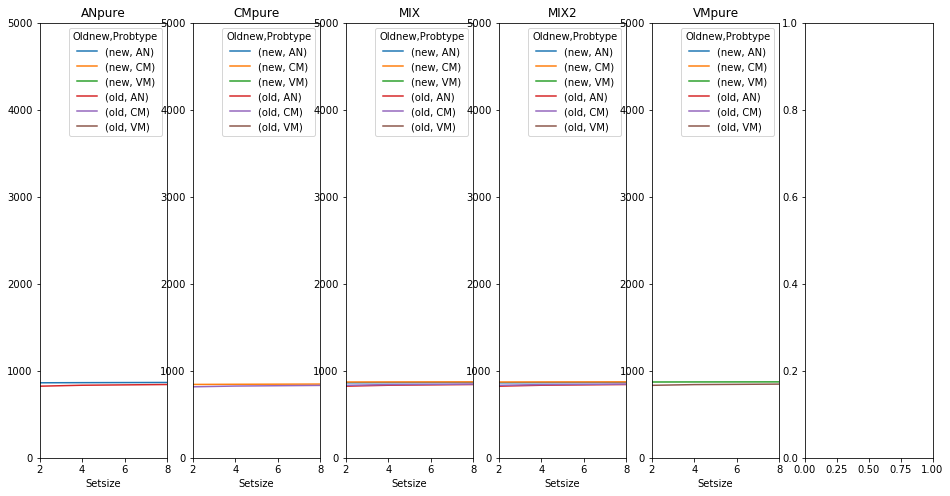

<Figure size 432x288 with 0 Axes>

In [66]:
# s_AN=0.01
# s_others = 0.07
def finalRW(df_what,kind):

    if kind == "err":
        df_what["Pred_error"] = 1-calc_theoretical_RW(df_what,kind)
    elif kind == "crt":
        df_what["Pred_cRT"]=calc_theoretical_RW(df_what,kind)
    else: print("error input of name kind")
    
    return(df_what)

def all_plot(df_all_err,plotwhaty,ylim):
    df_all_agg = df_all_err.groupby(["Oldnew","Setsize","Probtype","FileCondi"]).agg(["mean"])#.apply(lambda x: x)
    df_all_aggnew = df_all_agg.unstack(["Oldnew","Probtype"])
    df_all_aggnew.columns = df_all_aggnew.columns.droplevel([1])

#     df_all_aggnew.index.name = 'Setsize'
    df_all_aggnew.reset_index(inplace=True)
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16,8))
    fig.canvas.set_window_title(plotwhaty)
    line_width = 2.5
    i=0
    names = df_all_aggnew["FileCondi"].astype("category").cat.categories.to_numpy() #get categories name
    plt.figure()
    for iname in names:
        
        df_all_aggnew[df_all_aggnew["FileCondi"]==iname].plot.line(x="Setsize", y=plotwhaty,ax=axes[i],\
                                                                   title=iname,ylim=ylim )
        i+=1
    plt.show()
    plt.close()   
df_crt_pred = finalRW(df_crt,"crt")
df_err_pred = finalRW(df_err,"err")

all_plot(df_crt_pred,"Pred_cRT",(0,5000))

In [359]:
df_crt_pred = finalRW(df_crt,"crt")
df_err_pred = finalRW(df_err,"err")

In [360]:
df_err_pred

,index,Oldnew,Setsize,Probtype,Lag,FileCondi,Error,Pred_error
0,0,new,2,AN,0,ANpure,0.069414,2.438916e-11
1,1,new,2,AN,0,MIX,0.028037,1.581498e-01
2,2,new,2,AN,0,MIX2,0.031712,1.350352e-02
3,3,new,2,CM,0,CMpure,0.030896,2.496033e-02
4,4,new,2,CM,0,MIX,0.039046,5.665066e-06
...,...,...,...,...,...,...,...,...
114,114,old,8,VM,4,VMpure,0.208696,8.919739e-01
115,115,old,8,VM,5,VMpure,0.170940,8.930421e-01
116,116,old,8,VM,6,VMpure,0.327869,8.934260e-01
117,117,old,8,VM,7,VMpure,0.252033,8.935906e-01


In [224]:
source("functions_fromr.r")

In [361]:
%get df_crt_pred --from Python3
%get df_err_pred --from Python3
%get df0 --from Python3

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


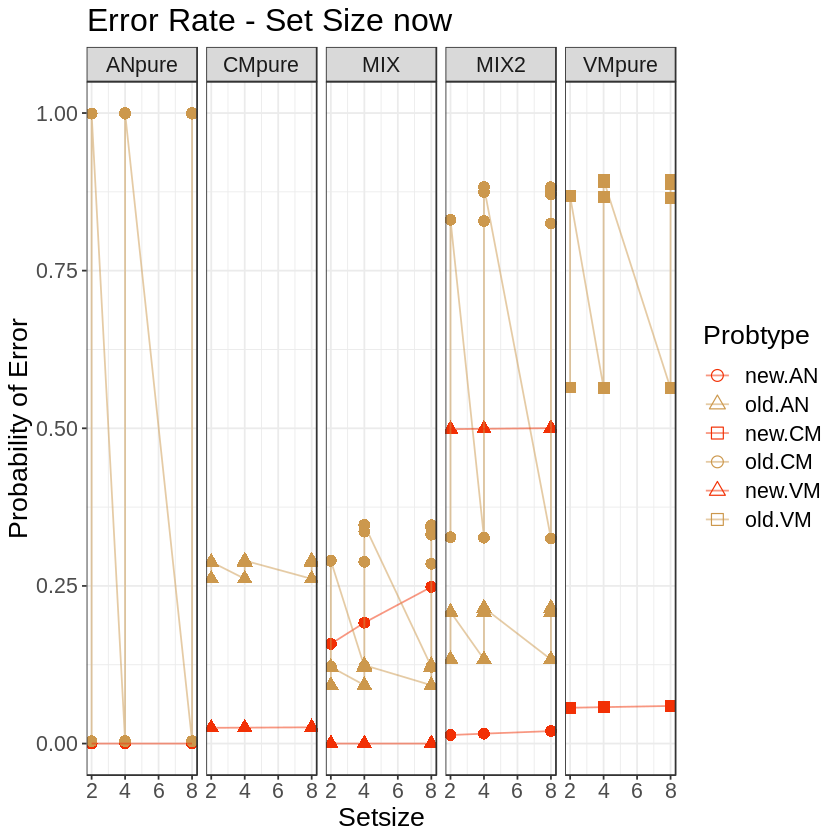

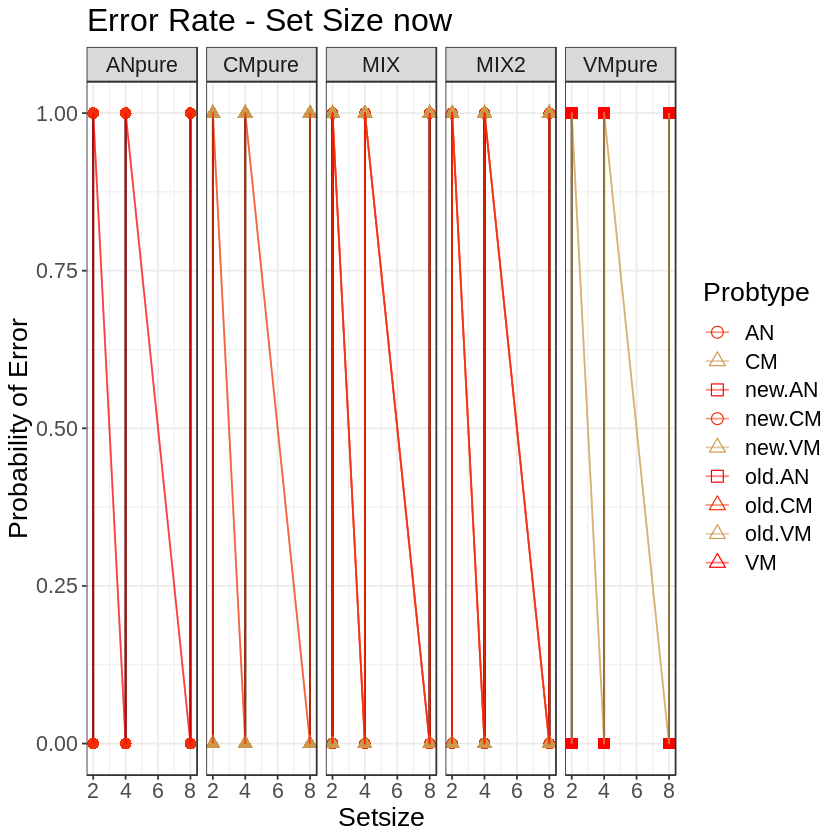

In [382]:
p.ER.pred=function(d,tit){
    override.shape = c(1,2,0,1,2,0)
  p=ggplot(data=d,aes(Setsize,Pred_error))+
    geom_point(aes(color=interaction(Oldnew,Probtype),shape=as.factor(Probtype),group=Oldnew),size=3)+
      geom_line(aes(color=interaction(Oldnew,Probtype),#linetype=as.factor(FileCondi),
                    group=interaction(Oldnew,Probtype)),lwd=0.5,alpha=0.5)+
      scale_color_manual(name="Probtype",
                         values=c(rep(c("#F23005","#CC984D"),3)))+
    scale_shape_discrete(guide=FALSE)+
    ggtitle(paste("Error Rate - Set Size",tit))+
    theme_bw()+
    theme(text=element_text(size=16))+
    ylim(0,0.25)+
    guides(colour = guide_legend(override.aes=list(shape=override.shape)))+
    facet_wrap(FileCondi~.,ncol=6)+
    scale_y_continuous("Probability of Error")
  return(p)
}
p.ER.org=function(d,tit){
    override.shape = c(1,2,0,1,2,0,2,2,2)
  d0= d 
  dase= d %>% group_by(FileCondi,Oldnew,Setsize,Probtype,Correctness) %>%
    dplyr::summarize(Error=mean(Correctness),se=sd(Correctness)/sqrt(n()))
  # print(dase)
  da1se=dase
  p=ggplot(data=da1se,aes(Setsize,Error))+
    geom_errorbar(aes(ymin=(Error-se), ymax=(1-Correctness)+se), width=.2,
                  position=position_dodge(.9),alpha=0.5) +
    geom_point(aes(color=Probtype,shape=as.factor(Probtype),group=Oldnew),size=3)+
      geom_line(aes(color=interaction(Oldnew,Probtype),#linetype=as.factor(FileCondi),
                    group=interaction(Oldnew,Probtype)),lwd=0.5,alpha=0.5)+
      scale_color_manual(name="Probtype",
                         values=c(rep(c("#F23005","#CC984D","red"),3)))+
    scale_shape_discrete(guide=FALSE)+
    ggtitle(paste("Error Rate - Set Size",tit))+
    theme_bw()+
    theme(text=element_text(size=16))+
    ylim(0,0.25)+
    guides(colour = guide_legend(override.aes=list(shape=override.shape)))+
    facet_wrap(FileCondi~.,ncol=6)+
    scale_y_continuous("Probability of Error")#+
#     coord_fixed(ratio=0.08)
  return(p)
}
p.ER.pred(df_err_pred,"now")
p.ER.org(df0,"now")

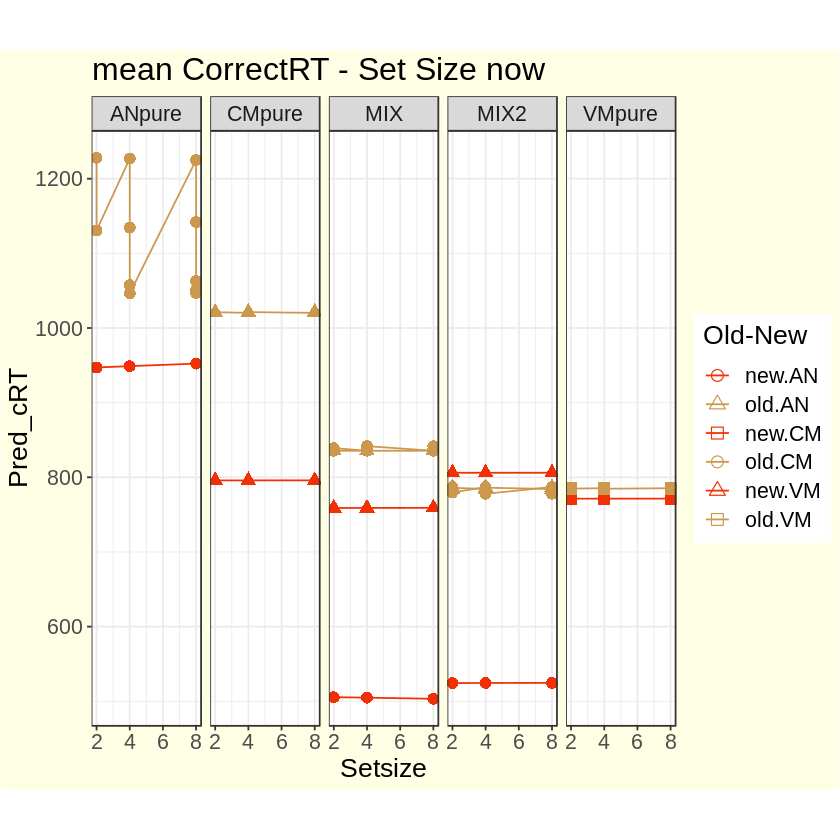

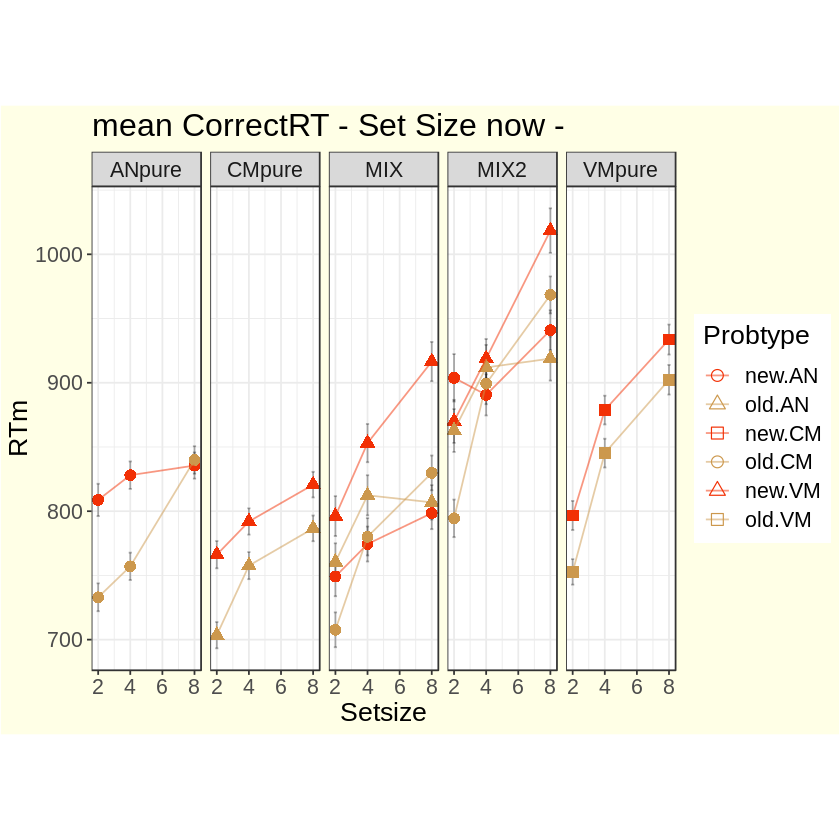

In [347]:
source("functions_fromr.r")
p.meanRT.pred(df_crt_pred,"now")
p.meanRT.org(df0,"now")